In [4]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)
    
from src.predictionModule.TreeTimeML import TreeTimeML

import pandas as pd
import numpy as np
import polars as pl
import datetime
import seaborn as sns
import lightgbm as lgb
import random
import matplotlib.pyplot as plt
import logging
logging.basicConfig(
    level=logging.DEBUG,
    format='%(message)s'
)
logger = logging.getLogger(__name__)

In [41]:
params = {
    "daysAfterPrediction": 7,
    'timesteps': 22,
    'target_option': 'last',
    "TreeTime_isFiltered": False,
    "TreeTime_top_highest": 10,
}

stock_group = "group_snp500_finanTo2011"

eval_date = datetime.date(year=2025, month=2, day=13)
start_train_date = datetime.date(year=2024, month=1, day=1)

treetimeML = TreeTimeML(
    train_start_date=start_train_date,
    test_dates=[eval_date],
    group=stock_group,
    params=params,
)

In [42]:
treetimeML.load_and_filter_sets(main_path = "../src/featureAlchemy/bin/")

In [43]:
Xtree = treetimeML.train_Xtree
ytree = treetimeML.train_ytree
ytime = treetimeML.train_ytime

treenames = treetimeML.featureTreeNames

In [44]:
np.mean(ytree)

np.float32(1.0025084)

# RSI Stats

In [45]:
q = 0.5
idx = np.where(treenames == 'FeatureTA_momentum_stoch_rsi')[0]
arr = Xtree[:, idx].flatten()
quant_lower = np.quantile(arr, q)
#quant_upper = np.quantile(arr, 1-q)
mask = np.zeros_like(arr, dtype=bool)
mask = mask | (arr <= quant_lower)
#mask = mask | (arr >= quant_upper)

print(f"Ratio of chosen: {mask.sum()/len(mask)}")
print(np.mean(ytree[mask]))

Ratio of chosen: 0.5
1.0032235


# RSME Stats

### RSME 1, with intermediate value

In [58]:
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == 'Fourier_Price_RSMERatioCoeff_1_MH_1')[0]
    idx1 = np.where(treenames == 'FeatureTA_Open_lag_m1')[0]
    idx2 = np.where(treenames == 'FeatureTA_Open_lag_m10')[0]
    arr = Xtree[:, idx].flatten()
    arr1 = Xtree[:, idx1].flatten()
    arr2 = Xtree[:, idx2].flatten()
    mask = mask | (arr2 < arr1*0.98)
    quant = np.quantile(arr[(arr2 < arr1*0.98)], q)
    mask = mask | (arr <= quant)
    return mask

n_q = 10
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.01, 0.10, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(masksum/Xtree.shape[0])
print(returns)

[0.55550956 0.56006268 0.56445318 0.56876977 0.57345593 0.57772817
 0.58208911 0.58647961 0.59017532 0.59419626]
[1.00226545 1.00228107 1.00229442 1.00230443 1.00231707 1.00232828
 1.00236642 1.0023911  1.00243962 1.002455  ]


### RSME 1, with out intermediate value

[0.001      0.00807143 0.01514286 0.02221429 0.02928571 0.03635714
 0.04342857 0.0505     0.05757143 0.06464286 0.07171429 0.07878571
 0.08585714 0.09292857 0.1       ]
[0.00100523 0.00807143 0.01515241 0.02221861 0.02929959 0.03636579
 0.04343198 0.05051296 0.05757916 0.06464536 0.07172634 0.07879254
 0.08585874 0.09293972 0.10000591]
[1.00562847 1.00621033 1.0045439  1.00311279 1.00254631 1.00305271
 1.00332046 1.00322974 1.00303197 1.00298488 1.00282419 1.00272143
 1.00263488 1.00246716 1.00258183]


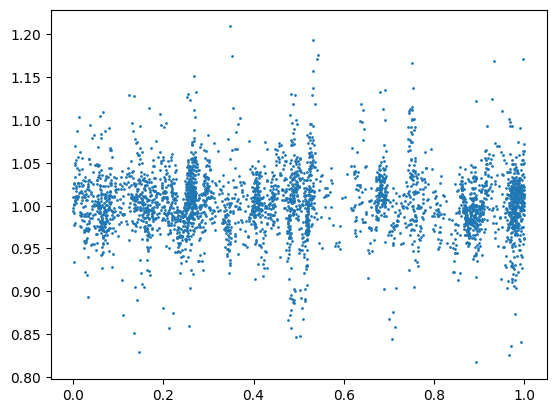

In [59]:
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == 'Fourier_Price_RSMERatioCoeff_1_MH_2')[0]
    arr = Xtree[:, idx].flatten()
    quant = np.quantile(arr, q)
    mask = mask | (arr <= quant)
    return mask

n_q = 15
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.001, 0.10, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum/Xtree.shape[0])
print(returns)

mask = f(0.05)
mask_idc = np.where(mask)[0]
diff_mask = np.diff(np.insert(mask_idc, 0, 1))
idx = np.where(treenames == 'Fourier_Price_RSMERatioCoeff_1_MH_2')[0]
plt.scatter(np.cumsum(diff_mask)/np.sum(diff_mask), ytree[mask], s=1)
plt.show()

### RSME 1 mhx, with out intermediate value

[0.001  0.0019 0.0028 0.0037 0.0046 0.0055 0.0064 0.0073 0.0082 0.0091
 0.01  ]
[0.00153742 0.00273483 0.00399137 0.00552878 0.00709576 0.0086184
 0.01015581 0.01166366 0.01315673 0.01472371 0.01626112]
[0.99563068 0.99991107 1.00164902 1.00502789 1.00626993 1.00749028
 1.00729907 1.00766611 1.00738668 1.00830758 1.00838006]


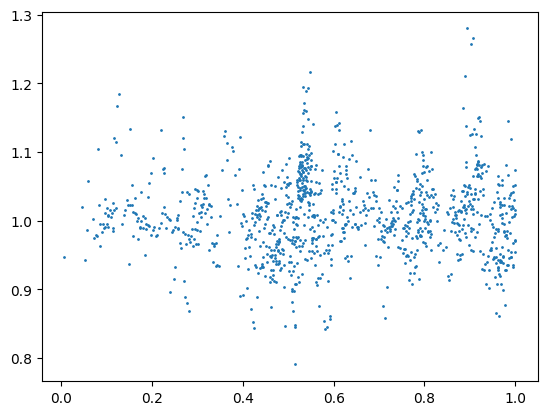

In [61]:
m = 1
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    #idx = np.where(treenames == f'Fourier_Price_RSMECoeff_1_MH_{m}')[0]
    idx2 = np.where(treenames == 'FeatureTA_volatility_atr')[0]
    idx3 = np.where(treenames == f'FeatureTA_trend_kst')[0]
    #arr = Xtree[:, idx].flatten()
    arr2 = Xtree[:, idx2].flatten()
    arr3 = Xtree[:, idx3].flatten()
    #quant = np.quantile(arr, q)
    quant2 = np.quantile(arr2, 1-q)
    quant3 = np.quantile(arr3, q)
    #mask1 = (arr < quant)
    mask2 = (arr2 >= quant2)
    mask3 = (arr3 < quant3)
    mask = mask | ( mask2 | mask3)
    return mask

n_q = 11
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.001, 0.01, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum/Xtree.shape[0])
print(returns)

mask = f(0.01)
mask_idc = np.where(mask)[0]
diff_mask = np.diff(np.insert(mask_idc, 0, 1))
plt.scatter(np.cumsum(diff_mask)/np.sum(diff_mask), ytree[mask], s=1)
plt.show()

# ebit

In [62]:
qm = 5
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == f'FinData_quar_ebit_lagquot_qm{qm}')[0]
    arr = Xtree[:, idx].flatten()
    quant = np.quantile(arr, 1-q)
    mask = mask | (arr >= quant)
    return mask

n_q = 15
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.01, 0.2, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum)
print(returns)

[0.01       0.02357143 0.03714286 0.05071429 0.06428571 0.07785714
 0.09142857 0.105      0.11857143 0.13214286 0.14571429 0.15928571
 0.17285714 0.18642857 0.2       ]
[  697  1629  2550  3487  4364  5318  6227  7126  8076  8995  9909 10810
 11711 12648 13569]
[1.01188588 1.00879645 1.00800669 1.00724924 1.0069139  1.00630176
 1.00605309 1.00589085 1.00546563 1.00495327 1.00499356 1.00487375
 1.00474513 1.00484693 1.00456858]


# Group Dynamic, FeatureGroup_RetGrLvl

In [50]:
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == f'FeatureGroup_RetGrLvl')[0]
    arr = Xtree[:, idx].flatten()
    quant = np.quantile(arr, q)
    mask = mask | (arr >= quant)
    return mask

n_q = 15
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.98, 0.99, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum)
print(returns)

[0.98       0.98071429 0.98142857 0.98214286 0.98285714 0.98357143
 0.98428571 0.985      0.98571429 0.98642857 0.98714286 0.98785714
 0.98857143 0.98928571 0.99      ]
[1353 1305 1257 1208 1160 1112 1063 1015  967  919  870  822  774  725
  677]
[1.0010457  1.00094903 1.00072372 1.00052702 1.00009561 0.99987066
 1.00013733 1.00069833 1.00063121 1.00098288 1.0009656  1.00118244
 1.00092471 1.00087774 1.00154197]


# TA Features

[0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
[6089 5412 4736 4059 3383 2706 2030 1353  677]
[0.09001271 0.08000473 0.07001153 0.06000355 0.05001035 0.04000237
 0.03000917 0.02000118 0.01000798]
[1.00408423 1.00383675 1.00358748 1.0029732  1.00280583 1.0022577
 1.00322437 1.00509083 1.01296365]


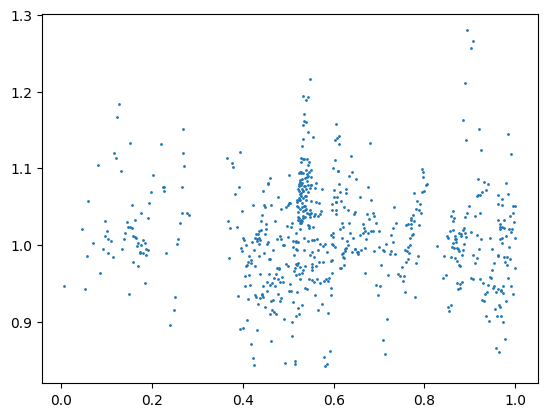

Mean of rolling means: 1.0131301579539647
Std dev of rolling means: 0.03933795076083414


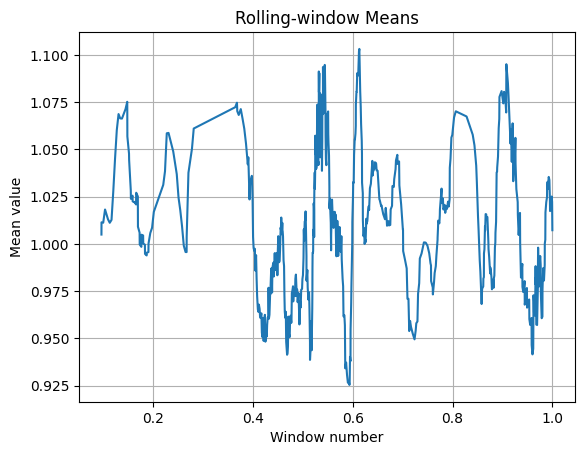

In [66]:
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == 'FeatureTA_volatility_atr')[0]
    arr = Xtree[:, idx].flatten()
    quant = np.quantile(arr, q)
    mask = mask | (arr >= quant)
    return mask

n_q = 9
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.91, 0.99, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum)
print(masksum/Xtree.shape[0])
print(returns)

mask = f(0.99)
mask_idc = np.where(mask)[0]
diff_mask = np.diff(np.insert(mask_idc, 0, 1))
idx = np.where(treenames == 'FeatureTA_volatility_atr')[0]
plt.scatter(np.cumsum(diff_mask)/np.sum(diff_mask), ytree[mask], s=1)
plt.show()

s = pd.Series(ytree[mask])
rolling_means = s.rolling(window=10).mean()
mean_of_means = rolling_means.mean()
std_of_means  = rolling_means.std()
print("Mean of rolling means:", mean_of_means)
print("Std dev of rolling means:", std_of_means)

plt.plot(np.cumsum(diff_mask)/np.sum(diff_mask), rolling_means.values)
plt.title('Rolling-window Means')
plt.xlabel('Window number')
plt.ylabel('Mean value')
plt.grid(True)
plt.show()

In [52]:
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == f'FeatureTA_trend_kst')[0]
    arr = Xtree[:, idx].flatten()
    quant = np.quantile(arr, q)
    mask = mask | (arr <= quant)
    return mask

n_q = 11
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.01, 0.10, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum)
print(returns)

[0.01  0.019 0.028 0.037 0.046 0.055 0.064 0.073 0.082 0.091 0.1  ]
[ 677 1286 1895 2503 3112 3721 4330 4939 5547 6156 6765]
[1.00500464 1.00705791 1.00539684 1.00547326 1.00547636 1.00485992
 1.00469851 1.00449395 1.00439405 1.00451207 1.00454414]


[0.91       0.91421053 0.91842105 0.92263158 0.92684211 0.93105263
 0.93526316 0.93947368 0.94368421 0.94789474 0.95210526 0.95631579
 0.96052632 0.96473684 0.96894737 0.97315789 0.97736842 0.98157895
 0.98578947 0.99      ]
[6089 5804 5519 5234 4949 4664 4380 4095 3811 3525 3240 2956 2671 2386
 2101 1816 1531 1247  962  677]
[1.00717676 1.007375   1.00760758 1.00780559 1.00780141 1.00783324
 1.00799119 1.00819743 1.0082804  1.00838459 1.00833249 1.00846446
 1.00856555 1.00864053 1.00882304 1.00884819 1.00901294 1.00914347
 1.00831437 1.00722671]


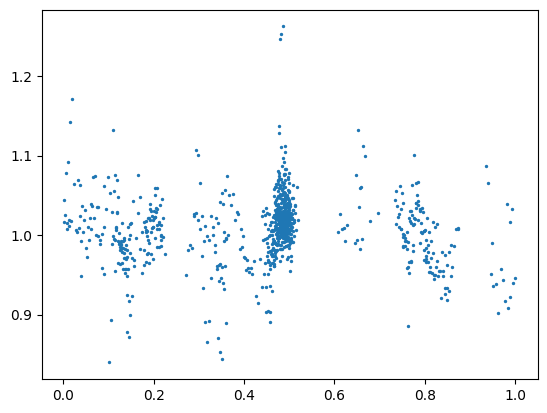

Mean of returns: 1.0090027
Mean of rolling means: 1.0109848377974013
Std dev of rolling means: 0.01592492460518183


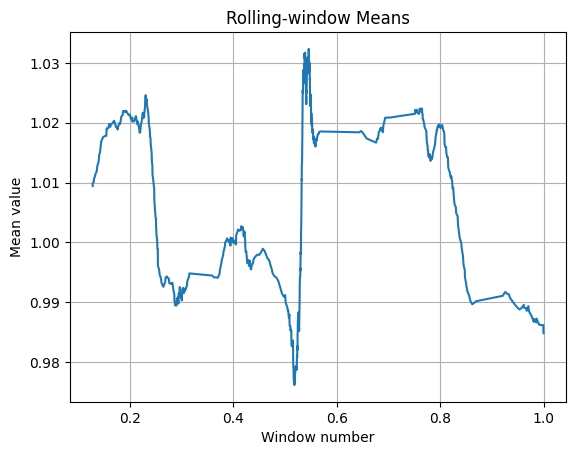

In [53]:
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == f'FeatureTA_trend_mass_index')[0]
    arr = Xtree[:, idx].flatten()
    quant = np.quantile(arr, q)
    mask = mask | (arr >= quant)
    return mask

n_q = 20
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.91, 0.99, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum)
print(returns)

mask = f(0.985)
mask_idc = np.where(mask)[0]
diff_mask = np.diff(np.insert(mask_idc, 0, 1))
dates = treetimeML.meta_pl_train.filter(mask).select("date")

res = ytree[mask]
trunc_rat_low = 0.1
trunc_rat_up = 0.99
res_trunc = res[int(len(res)*trunc_rat_low):int(len(res)*trunc_rat_up)]
diff_mask_trunc = diff_mask[int(len(res)*trunc_rat_low):int(len(res)*trunc_rat_up)]
plt.scatter(np.cumsum(diff_mask_trunc)/np.sum(diff_mask_trunc), res_trunc, s=2)
plt.show()
print("Mean of returns:", np.mean(res_trunc))

s = pd.Series(res)
rolling_means = s.rolling(window=100).mean()
mean_of_means = rolling_means.mean()
std_of_means  = rolling_means.std()
print("Mean of rolling means:", mean_of_means)
print("Std dev of rolling means:", std_of_means)

plt.plot(np.cumsum(diff_mask)/np.sum(diff_mask), rolling_means.values)
plt.title('Rolling-window Means')
plt.xlabel('Window number')
plt.ylabel('Mean value')
plt.grid(True)
plt.show()


# Math Features

[0.01       0.06157895 0.11315789 0.16473684 0.21631579 0.26789474
 0.31947368 0.37105263 0.42263158 0.47421053 0.52578947 0.57736842
 0.62894737 0.68052632 0.73210526 0.78368421 0.83526316 0.88684211
 0.93842105 0.99      ]
[  677  4166  7655 11144 14633 18122 21611 25100 28589 32078 35568 39057
 42546 46035 49524 53013 56502 59991 67646 67646]
[1.00734067 1.00467896 1.00430775 1.00344944 1.00328183 1.00320721
 1.00303376 1.00308359 1.00287712 1.00291574 1.00292683 1.002967
 1.00291908 1.00298345 1.00288367 1.00280201 1.0027262  1.00269032
 1.0025084  1.0025084 ]
Mean of rolling means: 1.005545947997848
Std dev of rolling means: 0.022524782437490287


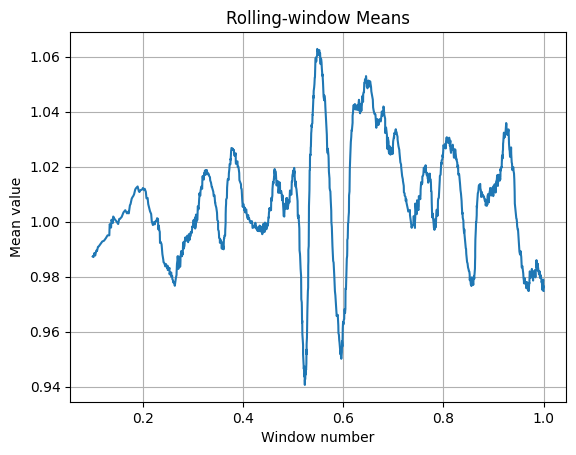

In [54]:
candidates = [
    'MathFeature_Drawdown_MH4',
    'MathFeature_Drawdown_MH5',
    'MathFeature_Drawdown_MH6',
]
# find the first one that actually appears in treenames
name = next((c for c in candidates if c in treenames), None)
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == name)[0]
    arr = Xtree[:, idx].flatten()
    quant = np.quantile(arr, q)
    mask = mask | (arr <= quant)
    return mask

n_q = 20
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.01, 0.99, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum)
print(returns)

mask = f(0.02)
mask_idc = np.where(mask)[0]
diff_mask = np.diff(np.insert(mask_idc, 0, 0))
dates = treetimeML.meta_pl_train.filter(mask).select("date")

s = pd.Series((ytree[mask]))
window=50
rolling_means = s.rolling(window=window).mean()
mean_of_means = rolling_means.mean()
std_of_means  = rolling_means.std()
print("Mean of rolling means:", mean_of_means)
print("Std dev of rolling means:", std_of_means)

plt.plot(np.cumsum(diff_mask)/np.sum(diff_mask), rolling_means.values)
plt.title('Rolling-window Means')
plt.xlabel('Window number')
plt.ylabel('Mean value')
plt.grid(True)
plt.show()

# ALL at once

In [67]:
q = 0.01
n_feats = Xtree.shape[1]
returns_le = np.zeros(n_feats)
returns_ge = np.zeros(n_feats)

for j in range(n_feats):
    col = Xtree[:, j]
    thresh_low = np.quantile(col, q)
    thresh_high = np.quantile(col, 1 - q)
    mask_le = col <= thresh_low
    mask_ge = col >= thresh_high
    returns_le[j] = np.mean(ytree[mask_le]) if mask_le.any() else np.nan
    returns_ge[j] = np.mean(ytree[mask_ge]) if mask_ge.any() else np.nan

results = pd.DataFrame({
    'feature': treenames,
    f'return_le': returns_le,
    f'return_ge': returns_ge,
}).set_index('feature')

print(results)

                                                return_le  return_ge
feature                                                             
Category_other                                   1.002508   1.002508
Category_industrials                             1.002659   1.001933
Category_healthcare                              1.002659   1.001491
Category_technology                              1.002339   1.003620
Category_financial-services                      1.002502   1.002594
...                                                   ...        ...
FeatureGroup_WeightedIndexMHPct_lag_m500_MH_2    1.001971   1.000967
FeatureGroup_WeightedIndexMHPct_lag_m500_MH_4    1.002351   1.008093
FeatureGroup_WeightedIndexMHPct_lag_m500_MH_6    1.003030   0.990393
FeatureGroup_WeightedIndexMHPct_lag_m500_MH_8    1.002793   0.991155
FeatureGroup_WeightedIndexMHPct_lag_m500_MH_12   1.002271   1.003980

[2829 rows x 2 columns]


In [56]:
res_sorted_le = results.sort_values(by='return_le', ascending=False)
res_sorted_ge = results.sort_values(by='return_ge', ascending=False)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# 1) train
split_ratio      = 0.6
n_total  = Xtree.shape[0]
mask_val = np.random.rand(n_total) >= split_ratio
X, y = Xtree, ytree
tree = DecisionTreeRegressor(max_leaf_nodes=20)  # adjust complexity
tree.fit(X, y)

# 2) leaf assignment & stats
leaf_ids = tree.apply(X)
uniq, counts = np.unique(leaf_ids, return_counts=True)
sums = np.array([y[leaf_ids==lid].sum() for lid in uniq])
# weight = counts, value = sums

# 3) 0/1-knapsack to pick leaves up to 10% of N
N = len(y)
K = int(0.05 * N)
# DP array: dp[w] = max sum achievable with total count w
dp = np.zeros(K+1)
pick = [[False]*len(uniq) for _ in range(K+1)]
for i, (w, v) in enumerate(zip(counts, sums)):
    for cap in range(K, w-1, -1):
        if dp[cap-w] + v > dp[cap]:
            dp[cap] = dp[cap-w] + v
            pick[cap] = pick[cap-w].copy()
            pick[cap][i] = True

# find best cap
best_w = np.argmax(dp)
chosen = [uniq[i] for i, used in enumerate(pick[best_w]) if used]

# 4) extract your subset
mask = np.isin(leaf_ids, chosen)
X_sel, y_sel = X[mask], y[mask]

print(f"Selected {len(y_sel)} samples (target mean={y_sel.mean():.3f})")

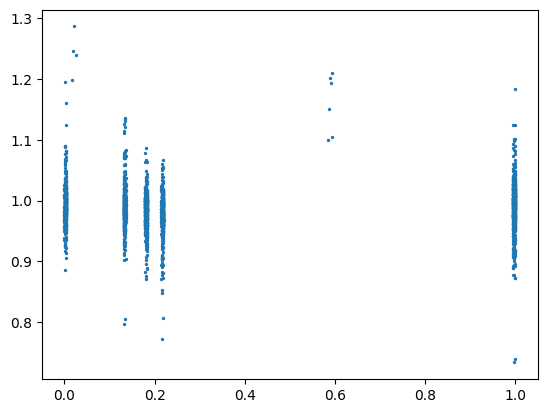

Mean of returns: 0.9879441
Mean of rolling means: 0.9879817862830802
Std dev of rolling means: 0.009214363115414287


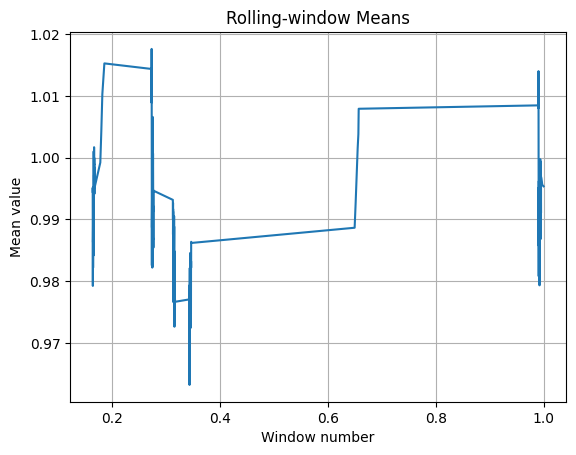

In [ ]:

mask_idc = np.where(mask)[0]
diff_mask = np.diff(np.insert(mask_idc, 0, 0))
dates = treetimeML.meta_pl_train.filter(mask).select("date")

res = ytree[mask]
trunc_rat_low = 0.02
trunc_rat_up = 0.99
res_trunc = res[int(len(res)*trunc_rat_low):int(len(res)*trunc_rat_up)]
diff_mask_trunc = diff_mask[int(len(res)*trunc_rat_low):int(len(res)*trunc_rat_up)]
plt.scatter(np.cumsum(diff_mask_trunc)/np.sum(diff_mask_trunc), res_trunc, s=2)
plt.show()
print("Mean of returns:", np.mean(res_trunc))

s = pd.Series((ytree[mask]))
window=50
rolling_means = s.rolling(window=window).mean()
mean_of_means = rolling_means.mean()
std_of_means  = rolling_means.std()
print("Mean of rolling means:", mean_of_means)
print("Std dev of rolling means:", std_of_means)

plt.plot(np.cumsum(diff_mask)/np.sum(diff_mask), rolling_means.values)
plt.title('Rolling-window Means')
plt.xlabel('Window number')
plt.ylabel('Mean value')
plt.grid(True)
plt.show()

## Combining all Feat

In [ ]:
df = pl.DataFrame({
    **{f"f{i}": Xtree[:,i] for i in range(n_feats)},
    "y":            ytree,
    "date":         treetimeML.meta_pl_train["date"]
})
long = df.melt(id_vars=["y","date"], variable_name="feature", value_name="value")

C:\Users\kimer\AppData\Local\Temp\ipykernel_14228\1062238412.py:6: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  long = df.melt(id_vars=["y","date"], variable_name="feature", value_name="value")


In [ ]:
q_arr = [0.005, 0.01, 0.02]
n_samples, n_feats = Xtree.shape
n_q = len(q_arr)
roll_window=200
returns_le = np.zeros((n_feats, n_q))
returns_ge = np.zeros((n_feats, n_q))
num_le     = np.zeros((n_feats, n_q), dtype=int)
num_ge     = np.zeros((n_feats, n_q), dtype=int)
roll_le_mean  = np.zeros((n_feats, n_q))
roll_le_stderr = np.zeros((n_feats, n_q))
roll_le_end_mean = np.zeros((n_feats, n_q))
roll_ge_mean  = np.zeros((n_feats, n_q))
roll_ge_stderr = np.zeros((n_feats, n_q))
roll_ge_end_mean = np.zeros((n_feats, n_q))
days_le = np.zeros((n_feats, n_q), dtype=int)
days_ge = np.zeros((n_feats, n_q), dtype=int)

for i, q in enumerate(q_arr):
    print(f"Processing quantile: {q}")
    
    thr_low  = np.quantile(Xtree,      q, axis=0)
    thr_high = np.quantile(Xtree, 1. - q, axis=0)

    # 2) boolean masks of shape (n_samples, n_feats)
    mask_le = Xtree <= thr_low
    mask_ge = Xtree >= thr_high
    
    # 3) vectorized sums & counts → means
    cnt_le = mask_le.sum(axis=0)
    cnt_ge = mask_ge.sum(axis=0)
    sum_le = (mask_le * ytree[:, None]).sum(axis=0)
    sum_ge = (mask_ge * ytree[:, None]).sum(axis=0)

    num_le[:, i]     = cnt_le
    num_ge[:, i]     = cnt_ge
    returns_le[:, i] = np.where(cnt_le>0, sum_le/cnt_le, np.nan)
    returns_ge[:, i] = np.where(cnt_ge>0, sum_ge/cnt_ge, np.nan)
    
    for j in range(n_feats):
        # roll le
        df_le = pl.DataFrame({"value": ytree[mask_le[:,j]]})
        df_le = (df_le.with_columns(pl.col("value")
                .rolling_mean(roll_window)
                .alias("rolling_mean"))
            .drop_nulls("rolling_mean"))
        stats_le = df_le.select([
            pl.col("rolling_mean").mean().alias("roll_mean"),
            pl.col("rolling_mean").std().alias("roll_stderr"),
            pl.col("rolling_mean").last().alias("roll_end_mean"),
        ])
        roll_le_mean[j, i]     = stats_le["roll_mean"][0]
        roll_le_stderr[j, i]   = stats_le["roll_stderr"][0]
        roll_le_end_mean[j, i] = stats_le["roll_end_mean"][0]
        
        # roll ge
        df_ge = pl.DataFrame({"value": ytree[mask_ge[:,j]]})
        df_ge = (df_ge.with_columns(pl.col("value")
                .rolling_mean(roll_window)
                .alias("rolling_mean"))
            .drop_nulls("rolling_mean"))
        stats_ge = df_ge.select([
            pl.col("rolling_mean").mean().alias("roll_mean"),
            pl.col("rolling_mean").std().alias("roll_stderr"),
            pl.col("rolling_mean").last().alias("roll_end_mean"),
        ])
        roll_ge_mean[j, i]     = stats_ge["roll_mean"][0]
        roll_ge_stderr[j, i]   = stats_ge["roll_stderr"][0]
        roll_ge_end_mean[j, i] = stats_ge["roll_end_mean"][0]
        
        # dates
        days_le[j, i] = treetimeML.meta_pl_train.filter(mask_le[:,j]).select("date").unique().to_series().sort().diff().drop_nans().max().days
        days_ge[j, i] = treetimeML.meta_pl_train.filter(mask_ge[:,j]).select("date").unique().to_series().sort().diff().drop_nans().max().days


results = pl.DataFrame({
    'feature': treenames,
    **{f'return_le_{int(q*1000)}': returns_le[:,i] for i, q in enumerate(q_arr)},
    **{f'return_ge_{int(q*1000)}': returns_ge[:,i] for i, q in enumerate(q_arr)},
    **{f'num_le_{int(q*1000)}': num_le[:,i] for i, q in enumerate(q_arr)},
    **{f'num_ge_{int(q*1000)}': num_ge[:,i] for i, q in enumerate(q_arr)},
    **{f'roll_le_mean_{int(q*1000)}': roll_le_mean[:,i] for i, q in enumerate(q_arr)},
    **{f'roll_le_stderr_{int(q*1000)}': roll_le_stderr[:,i] for i, q in enumerate(q_arr)},
    **{f'roll_le_end_mean_{int(q*1000)}': roll_le_end_mean[:,i] for i, q in enumerate(q_arr)},
    **{f'roll_ge_mean_{int(q*1000)}': roll_ge_mean[:,i] for i, q in enumerate(q_arr)},
    **{f'roll_ge_stderr_{int(q*1000)}': roll_ge_stderr[:,i] for i, q in enumerate(q_arr)},
    **{f'roll_ge_end_mean_{int(q*1000)}': roll_ge_end_mean[:,i] for i, q in enumerate(q_arr)},
    **{f'days_le_{int(q*1000)}': days_le[:,i] for i, q in enumerate(q_arr)},
    **{f'days_ge_{int(q*1000)}': days_ge[:,i] for i, q in enumerate(q_arr)},
})

results

Processing quantile: 0.005
Processing quantile: 0.01
Processing quantile: 0.02


feature,return_le_5,return_le_10,return_le_20,return_ge_5,return_ge_10,return_ge_20,num_le_5,num_le_10,num_le_20,num_ge_5,num_ge_10,num_ge_20,roll_le_mean_5,roll_le_mean_10,roll_le_mean_20,roll_le_stderr_5,roll_le_stderr_10,roll_le_stderr_20,roll_le_end_mean_5,roll_le_end_mean_10,roll_le_end_mean_20,roll_ge_mean_5,roll_ge_mean_10,roll_ge_mean_20,roll_ge_stderr_5,roll_ge_stderr_10,roll_ge_stderr_20,roll_ge_end_mean_5,roll_ge_end_mean_10,roll_ge_end_mean_20,days_le_5,days_le_10,days_le_20,days_ge_5,days_ge_10,days_ge_20
str,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64
"""Category_other""",1.002424,1.002424,1.002424,1.002424,1.002424,1.002424,668331,668331,668331,668331,668331,668331,1.002489,1.002489,1.002489,0.0214,0.0214,0.0214,1.002057,1.002057,1.002057,1.002489,1.002489,1.002489,0.0214,0.0214,0.0214,1.002057,1.002057,1.002057,4,4,4,4,4,4
"""Category_industrials""",1.002504,1.002504,1.002504,1.002453,1.002453,1.002453,528588,528588,528588,139743,139743,139743,1.002497,1.002497,1.002497,0.021229,0.021229,0.021229,1.002556,1.002556,1.002556,1.002454,1.002454,1.002454,0.01926,0.01926,0.01926,1.000829,1.000829,1.000829,4,4,4,4,4,4
"""Category_healthcare""",1.002478,1.002478,1.002478,1.002276,1.002276,1.002276,581607,581607,581607,86724,86724,86724,1.002519,1.002519,1.002519,0.021527,0.021527,0.021527,1.004851,1.004851,1.004851,1.002285,1.002285,1.002285,0.016417,0.016417,0.016417,0.985975,0.985975,0.985975,4,4,4,4,4,4
"""Category_technology""",1.002386,1.002386,1.002386,1.002901,1.002901,1.002901,578937,578937,578937,89394,89394,89394,1.002425,1.002425,1.002425,0.021241,0.021241,0.021241,1.003708,1.003708,1.003708,1.002905,1.002905,1.002905,0.017867,0.017867,0.017867,0.998674,0.998674,0.998674,4,4,4,4,4,4
"""Category_financial-services""",1.00244,1.00244,1.00244,1.002673,1.002673,1.002673,623372,623372,623372,44959,44959,44959,1.002475,1.002475,1.002475,0.021419,0.021419,0.021419,1.005988,1.005988,1.005988,1.00272,1.00272,1.00272,0.013439,0.013439,0.013439,0.991525,0.991525,0.991525,4,4,4,4,4,4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""FeatureGroup_WeightedIndexMHPc…",1.002461,1.002461,1.002461,1.001007,1.004588,1.004603,621933,621933,621933,5639,7787,32866,1.002508,1.002508,1.002508,0.020933,0.020933,0.020933,1.002468,1.002468,1.002468,1.001181,1.004808,1.004652,0.015772,0.017813,0.017486,1.003049,1.003049,1.003049,7,7,7,2766,1203,217
"""FeatureGroup_WeightedIndexMHPc…",1.002471,1.002471,1.002471,0.996333,0.998737,0.998737,624379,624379,624379,3821,17678,17678,1.002518,1.002518,1.002518,0.021639,0.021639,0.021639,1.002057,1.002057,1.002057,0.99603,0.998802,0.998802,0.010908,0.013782,0.013782,1.020964,1.006604,1.006604,6,6,6,2719,870,870
"""FeatureGroup_WeightedIndexMHPc…",1.002403,1.002403,1.002403,0.999037,1.002837,1.001599,624518,624518,624518,4444,12802,32125,1.002463,1.002463,1.002463,0.021272,0.021272,0.021272,1.002057,1.002057,1.002057,0.999313,1.002883,1.001605,0.014522,0.017267,0.021234,0.992038,0.992038,0.992038,6,6,6,2798,1043,371


In [ ]:
names_le = ([f"roll_le_end_mean_{int(q*1000)}" for q in q_arr])
names_ge = ([f"roll_ge_end_mean_{int(q*1000)}" for q in q_arr])

res = results.with_columns([
    pl.col(f"roll_le_end_mean_{int(q*1000)}").alias(f"score_raw_le_q{q}") for q in q_arr
] + [
    pl.col(f"roll_ge_end_mean_{int(q*1000)}").alias(f"score_raw_ge_q{q}") for q in q_arr
])

res = res.with_columns([
        (pl.col(f"roll_le_end_mean_{int(q*1000)}") 
            * pl.when(pl.col(f'num_le_{int(q*1000)}') < (n_samples*q)).then(0.0).otherwise(1.0)
            * pl.when((1.0 - pl.col(f'roll_le_stderr_{int(q*1000)}')) < 0).then(0.0).otherwise((1.0 - pl.col(f'roll_le_stderr_{int(q*1000)}')))
            * pl.when(pl.col(f'days_le_{int(q*1000)}') > 100.0).then(0.0).otherwise(1.0))
        .alias(f"score_le_q{q}") for q in q_arr
    ] + [
        (pl.col(f"roll_ge_end_mean_{int(q*1000)}")
            * pl.when(pl.col(f'num_ge_{int(q*1000)}') < (n_samples*q)).then(0.0).otherwise(1.0)
            * pl.when(pl.when(pl.col(f'num_ge_{int(q*1000)}') < (n_samples*q)).then(0.0).otherwise(1.0) < 0).then(0.0).otherwise(pl.when(pl.col(f'num_ge_{int(q*1000)}') < (n_samples*q)).then(0.0).otherwise(1.0))
            * pl.when(pl.col(f'days_ge_{int(q*1000)}') > 100.0).then(0.0).otherwise(1.0))
        .alias(f"score_ge_q{q}") for q in q_arr
    ])

res = res.with_columns([
    (pl.when(pl.col(f"score_le_q{q}") > pl.col(f"score_ge_q{q}")).then(pl.col(f"score_le_q{q}"))
        .otherwise(pl.col(f"score_ge_q{q}")))
    .alias(f"score_q{q}") 
    for q in q_arr
])
    
scores_df = res.select(['feature'] + [f"score_raw_le_q{q}" for q in q_arr] + [f"score_raw_ge_q{q}" for q in q_arr] + [f"score_le_q{q}" for q in q_arr] + [f"score_ge_q{q}" for q in q_arr] + [f"score_q{q}" for q in q_arr])